# Cultural Parameter Optimization - Warlike

### **3T-9L1R: 3 Teams composed of 9 agents (3 agents per team) and 1 Random Agent**

Teams with Warlike culture require much longer training episodes, so we have a separate notebook specifically for  them.

In [1]:
import os
import random
import time
import pickle
import platform
import torch
import gym
import numpy as np

# This is the Gathering Game Environment based on Tribal Organization of agents
from tribes_env import GatheringEnv
from tribes_model import *

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())
print("Pytorch version: {}".format(torch.__version__))
print("OpenAI Gym version: {}".format(gym.__version__))

Python version:  3.6.4
Pytorch version: 0.4.1.post2
OpenAI Gym version: 0.9.2


## Culture = Warlike

Run finish_episode() specific to this culture.

In [2]:
def finish_episode(learners, optimizers, gamma, cuda):
    """ 
    Note that in RL, policy gradient is calculated at the end of an episode and only then used to 
    update the weights of an agent's policy. This is very different compared to image recog.
    
    The code will perform policy update on each learning agent independently. Reward for each time 
    step is stored in the list policy.rewards[] --> r(t)
    """  
    
    num_learners = len(learners)
    total_norms = [0 for i in range(num_learners)]
    policy_losses = [[] for i in range(num_learners)]
    losses = [[] for i in range(num_learners)]
    T_reward = []

   
    for i in range(num_learners):

        R = 0
        saved_actions = learners[i].saved_actions
        
        for t in tribes:
            if t.name is learners[i].tribe:
                T_reward = t.tribal_awards(US_hits = learners[i].US_hits,THEM_hits = learners[i].THEM_hits)
 
                # For debug only
                # print('Agent{} receives tribal award from Tribe{}'.format(i,t.name))
                # print (T_reward)
                # print (learners[i].rewards)
                
        # Do not implement actor-critic for now
        # value_losses = []
        
        rewards = deque()

        for r,T in zip(learners[i].rewards[::-1],T_reward[::-1]):
            # The agent is incentivized to cooperate by an award of 30% of what the tribe takes
            # in by all its members
            R = r + T + gamma * R
            rewards.appendleft(R)
            
        rewards = list(rewards)
        rewards = torch.Tensor(rewards)
        if cuda:
            rewards = rewards.cuda()

        # z-score rewards
        rewards = (rewards - rewards.mean()) / (1.1e-7+rewards.std())
        
        #Debug     
        #print (rewards)       
        
        """
        Do not implement actor-critic for now!!!
        for (log_prob, state_value), r in zip(saved_actions, rewards):
            reward = r - state_value.data[0]
            policy_losses.append(-log_prob * Variable(reward))
            r = torch.Tensor([r])
            if cuda:
                r = r.cuda()
            value_losses.append(torch.nn.functional.smooth_l1_loss(state_value,
                                                               Variable(r)))

        optimizer.zero_grad()
        loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
        loss.backward()        
        
        
        """
        for log_prob, r in zip(saved_actions, rewards):
            r = torch.Tensor([r])
            if cuda:
                r = r.cuda()
            policy_losses[i].append(-log_prob * Variable(r))

        optimizers[i].zero_grad()
        losses[i] = torch.stack(policy_losses[i]).sum()
        losses[i].backward()
        
        # Gradient Clipping Update: prevent exploding gradient
        total_norms[i] = torch.nn.utils.clip_grad_norm_(learners[i].parameters(), 8000)
        
        optimizers[i].step()
        learners[i].clear_history()   # clear an agent's history at the end of episode


    return total_norms

## Special Case - Warlike Culture

We discovered that if we run training of only 300 game steps, the agents with Warlike culture will spend the 1st hundreds of steps in mutually assured destruction - a field of deadly crossfire which they cannot escape out of.

So we lengthen the game step to 1000 instead.

In [3]:
import gym
import sys
import pickle
from collections import deque

import torch
import torch.optim as optim
from torch.autograd import Variable
import numpy as np

# Initialize agents parameters
#   10 agents - 9 learning agents, 0 trained agents, 1 random agents
num_learners = 9
num_trained = 0
num_rdn = 1
num_statics = num_trained + num_rdn
num_agents = num_learners + num_statics  

# Initialize environment
game = "Gather"
num_actions = 8                       # 8 actions in Gathering

# Initialize training parameters
warm_start = False
num_frames = 4      # environ observation consists of a list of 4 stacked frames per agent
max_episodes = 5000
max_frames = 1000
max_frames_ep = 0   # track highest number of frames an episode can last

# These trainer parameters works for Atari Breakout
gamma = 0.99  
lr = 1e-3
temp_start = 1.8  # Temperature for explore/exploit
temp_end = 1.0
log_interval = 100
save_interval = 500


def unpack_env_obs(env_obs):
    """
    Gathering is a partially-observable Markov Game. env_obs returned by GatheringEnv is a numpy 
    array of dimension (num_agent, 800), which represents the agents' observations of the game.

    The 800 elements (view_box) encodes 4 layers of 10x20 pixels frames in the format:
    (viewbox_width, viewbox_depth, 4).
    
    This code reshapes the above into stacked frames that can be accepted by the Policy class:
    (batch_idx, in_channel, width, height)
    
    """
    
    num_agents = len(env_obs)  # environ observations is a list of agents' observations
    
    obs = []
    for i in range(num_agents):
        x = env_obs[i]   # take the indexed agent's observation
        x = torch.Tensor(x)   # Convert to tensor
        
        # Policy is a 3-layer CNN
        x = x.view(1, 10, 20, -1)  # reshape into environment defined stacked frames
        x = x.permute(0, 3, 1, 2)  # permute to Policy accepted stacked frames
        obs.append(x)
        
    return obs  # return a list of Tensors


"""
For now, we do not implement LSTM            
# LSTM Change: Need to cycle hx and cx thru function
def select_action(model, state, lstm_hc, cuda):
    hx , cx = lstm_hc 
    num_frames, height, width = state.shape
    state = torch.FloatTensor(state.reshape(-1, num_frames, height, width))

    if cuda:
        state = state.cuda()

    probs, value, (hx, cx) = model((Variable(state), (hx, cx)))

    m = torch.distributions.Categorical(probs)
    action = m.sample()
    log_prob = m.log_prob(action)
    # LSTM Change: Need to cycle hx and cx thru function
    return action.data[0], log_prob, value, (hx, cx)
"""


def select_learner_action(model, obs, cuda):
    """
    This code expects obs to be an array of stacked frames of the following dim:
    (batch_idx, in_channel, width, height)
    
    This is inputted into model - the agent's Policy, which outputs a probability 
    distribution over available actions.
    
    Policy gradient is implemented using torch.distributions.Categorical. 
    """
    
    # Policy is a 3-layer CNN
    # _, num_frames, width, height = obs.shape
    # obs = torch.FloatTensor(obs.reshape(-1, num_frames, width, height))
    
    # Policy is a 2-layer NN for now
    # obs = obs.view(1, -1)
   
    if cuda:
        obs = obs.cuda()
      
    probs = model(obs)
    m = torch.distributions.Categorical(probs)
    action = m.sample()
    log_prob = m.log_prob(action)

    return action.item(), log_prob 


def load_info(agents, narrate=False):
    for i in range(num_agents):    
        agents[i].load_info(info[i])
        if narrate:
            if agents[i].tagged:
                print('frame {}, agent{} is tagged'.format(frame,i))
            if agents[i].laser_fired:
                print('frame {}, agent{} fires its laser'.format(frame,i))
                print('and hit {} US and {} THEM'.format(agents[i].US_hit, agents[i].THEM_hit))
    return


# The main code starts here!!!

cultures =[{'name':'warlike', 'penalty':-1.0, 'reward':0.075},
           {'name':'warlike', 'penalty':-1.0, 'reward':0.025}
          ]

"""
cultures =[{'name':'warlike', 'penalty':-1.0, 'reward':0.0001},
           {'name':'warlike', 'penalty':-1.0, 'reward':0.001},
           {'name':'warlike', 'penalty':-1.0, 'reward':0.005},
           {'name':'warlike', 'penalty':-1.0, 'reward':0.01},
           {'name':'warlike', 'penalty':-1.0, 'reward':0.05},
           {'name':'warlike', 'penalty':-1.0, 'reward':0.1},
           {'name':'warlike', 'penalty':-1.0, 'reward':0.5},
           {'name':'warlike', 'penalty':-1.0, 'reward':1.0}
          ]
"""

# Cultural parameter search
for culture in cultures:   # Go down the list of cultures

    # Data structure for agents
    agents = []
    actions = []
    log_probs = []
    tags = []
    rewards = []
    optimizers = []

    # Cold start
    if warm_start is False:
   
        # Initialize learner agents, then load static agents (trained followed by random)
        for i in range(num_learners):
            print("Learner agent {}".format(i))
            agents.append(Policy(num_frames, num_actions, i)) # No weights loaded for learning agent
            optimizers.append(optim.Adam(agents[i].parameters(), lr=lr))
        
            # set up optimizer - this works for Atari Breakout
            # optimizers.append(optim.RMSprop(agents[i].parameters(), lr=lr, weight_decay=0.1)) 
        
        for i in range(num_learners, num_learners+num_trained):
            print ("No trained agent exist yet!")
            raise
            """
            Disable for now! No trained model exist!!!
            agents.append(Policy(num_frames, num_actions, i))
            agents[i].load_weights()         # load weight for static agent        
            """
        for i in range(num_learners+num_trained, num_agents):
            print("Load random agent {}".format(i))
            agents.append(Rdn_Policy())

    
        # Initialize all agent data
        actions = [0 for i in range(num_agents)]
        log_probs = [0 for i in range(num_agents)]
        tags = [0 for i in range(num_agents)]
        rewards = [0 for i in range(num_agents)]

        # Keep track of rewards learned by learners
        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
        running_reward = [None for i in range(num_learners)]   # running average
        running_rewards = [[] for i in range(num_learners)]   # history of running averages
        best_reward = [0 for i in range(num_learners)]    # best running average (for storing best_model)

        # This is to support warm start for training
        prior_eps = 0

    # Warm start
    if warm_start:
        print ("Cannot warm start")
        raise
    
        """
        # Disable for now!  Need to ensure model can support training on GPU and game playing
        # on both CPU and GPU.
    
        data_file = 'results/{}.p'.format(game)

        try:
            with open(data_file, 'rb') as f:
                running_rewards = pickle.load(f)
                running_reward = running_rewards[-1]

            prior_eps = len(running_rewards)

            model_file = 'saved_models/actor_critic_{}_ep_{}.p'.format(game, prior_eps)
            with open(model_file, 'rb') as f:
                # Model Save and Load Update: Include both model and optim parameters
                saved_model = pickle.load(f)
                model, optimizer = saved_model

        except OSError:
            print('Saved file not found. Creating new cold start model.')
            model = Policy(input_channels=num_frames, num_actions=num_actions)
            optimizer = optim.RMSprop(model.parameters(), lr=lr,
                                      weight_decay=0.1)
            running_rewards = []
            prior_eps = 0
        """

    # Establish tribal association

    tribes = []
    tribes.append(Tribe(name='Vikings',color='blue', culture=culture, \
                    agents=[agents[0], agents[1], agents[2]]))
    tribes.append(Tribe(name='Saxons', color='red', culture=culture, \
                    agents=[agents[3], agents[4], agents[5]]))
    tribes.append(Tribe(name='Franks', color='purple', culture=culture, \
                    agents=[agents[6], agents[7], agents[8]]))
    tribes.append(Tribe(name='Crazies', color='yellow', agents=[agents[9]]))   # random agents are crazy!!!

    # 9 agents in 4 tribes, used map defined in default.txt
    agent_colors = [agent.color for agent in agents]
    agent_tribes = [agent.tribe for agent in agents]
    
    env = GatheringEnv(n_agents=num_agents,agent_colors=agent_colors, agent_tribes=agent_tribes, \
                       map_name='default')    
    
    cuda = torch.cuda.is_available()

    if cuda:
        for i in range(num_learners):    # Learning agents need to utilize GPU
            agents[i].cuda()

        
    for ep in range(max_episodes):
    
        print('.', end='')  # To show progress
    
        # Anneal temperature from temp_start to temp_end
        for i in range(num_learners):    # For learning agents
            agents[i].temperature = max(temp_end, temp_start - (temp_start - temp_end) * (ep / max_episodes))

        env_obs = env.reset()  # Env return observations

        # For Debug only
        # print (len(env_obs))
        # print (env_obs[0].shape)
    
        # Unpack observations into data structure compatible with agent Policy
        agents_obs = unpack_env_obs(env_obs)

        for i in range(num_learners):    # Reset agent info - laser tag statistics
            agents[i].reset_info()   

        # For Debug only
        # print (len(agents_obs))
        # print (agents_obs[0].shape)
    
        """
        For now, we do not stack observations, and we do not implement LSTM
    
        state = np.stack([state]*num_frames)

        # LSTM change - reset LSTM hidden units when episode begins
        cx = Variable(torch.zeros(1, 256))
        hx = Variable(torch.zeros(1, 256))
        if cuda:
            cx = cx.cuda()
            hx = hx.cuda()
        """

        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
    
        for frame in range(max_frames):

            """
            For now, we do not implement LSTM
            # Select action
            # LSTM Change: Need to cycle hx and cx thru select_action
            action, log_prob, value, (hx,cx)  = select_action(model, state, (hx,cx), cuda)        
            """

            for i in range(num_learners):    # For learning agents
                actions[i], log_probs[i] = select_learner_action(agents[i], agents_obs[i], cuda)
                if actions[i] is 6:
                    tags[i] += 1   # record a tag for accessing aggressiveness
                agents[i].saved_actions.append((log_probs[i]))
            
                # Do not implement LSTM for now
                # actions[i].saved_actions.append((log_prob, value))
            
            for i in range(num_learners, num_learners+num_trained):
                print ("No trained agent exist yet!")
                raise
            for i in range(num_learners+num_trained, num_agents):   # For random agents
                actions[i] = agents[i].select_action(agents_obs[i])
                if actions[i] is 6:
                    tags[i] += 1   # record a tag for accessing aggressiveness

            # For Debug only
            # if frame % 20 == 0:
            #    print (actions) 
            #    print (log_probs)
            
            # Perform step        
            env_obs, reward, done, info = env.step(actions)
        
            """
            For Debug only
            print (env_obs)
            print (reward)
            print (done) 
            """
       
            # Unpack observations into data structure compatible with agent Policy
            agents_obs = unpack_env_obs(env_obs)
            load_info(agents, narrate=False)   # Load agent info for AI agents

            # For learner agents only, generate reward statistics and reward stack for policy gradient
            for i in range(num_learners):
                agents[i].rewards.append(reward[i])  # Stack rewards (for policy gradient)
                episode_reward[i] += reward[i]   # accumulate episode reward 
            
            """
            For now, we do not stack observation, may come in handy later on
        
            # Evict oldest diff add new diff to state
            next_state = np.stack([next_state]*num_frames)
            next_state[1:, :, :] = state[:-1, :, :]
            state = next_state
            """

            if any(done):
                print("Done after {} frames".format(frame))
                break
            
        if frame > max_frames_ep:
            max_frames_ep = frame    # Keep track of highest frames/episode

        # Update reward statistics for learners
        for i in range(num_learners):
            if running_reward[i] is None:
                running_reward[i] = episode_reward[i]
            running_reward[i] = running_reward[i] * 0.99 + episode_reward[i] * 0.01
            running_rewards[i].append(running_reward[i])

        # Track Episode #, temp and highest frames/episode
        if (ep+prior_eps+1) % log_interval == 0: 
            verbose_str = '\nEpisode {} complete'.format(ep+prior_eps+1)
            # verbose_str += '\tTemp = {:.4}'.format(model.temperature)
            # verbose_str += '\tMax frames = {}'.format(max_frames_ep+1)
            print(verbose_str)
    
            # Display rewards and running rewards for learning agents
            for i in range(num_learners):
                verbose_str = 'Learner:{}'.format(i)
                verbose_str += '\tReward total:{}'.format(episode_reward[i])
                verbose_str += '\tRunning mean: {:.4}'.format(running_reward[i])
                print(verbose_str)
    
        # Update model
        total_norms = finish_episode(agents[0:num_learners], optimizers[0:num_learners], gamma, cuda)

        if (ep+prior_eps+1) % log_interval == 0:
            print('Max Norms = ',["%0.2f" % i for i in total_norms])
        
        if (ep+prior_eps+1) % save_interval == 0: 
            for i in range(num_learners):
                model_dir = 'MA_models/3T-9L1R/'
                results_dir = 'results/3T-9L1R/'

                model_file = model_dir+'{}/p{}_r{}/MA{}_{}__ep{}.p'.format(culture['name'], culture['penalty'],\
                                 culture['reward'], i, game, ep+prior_eps+1)
                data_file = results_dir+'{}/p{}_r{}/MA{}_{}.p'.format(culture['name'], culture['penalty'],\
                                                      culture['reward'], i, game)
                
                os.makedirs(os.path.dirname(model_file), exist_ok=True)
                os.makedirs(os.path.dirname(data_file), exist_ok=True)
                
                with open(model_file, 'wb') as f:
                    # Model Save and Load Update: Include both model and optim parameters 
                    pickle.dump((agents[i].cpu(), optimizers[i]), f)

                if cuda:
                    agents[i] = agents[i].cuda()

                with open(data_file, 'wb') as f:
                    pickle.dump(running_rewards[i], f)    
            
    env.close()  # Close the environment

Learner agent 0
Learner agent 1
Learner agent 2
Learner agent 3
Learner agent 4
Learner agent 5
Learner agent 6
Learner agent 7
Learner agent 8
Load random agent 9
....................................................................................................
Episode 100 complete
Learner:0	Reward total:0	Running mean: 0.03906
Learner:1	Reward total:1	Running mean: 0.3485
Learner:2	Reward total:0	Running mean: 0.8276
Learner:3	Reward total:0	Running mean: 0.6022
Learner:4	Reward total:0	Running mean: 0.08654
Learner:5	Reward total:2	Running mean: 1.286
Learner:6	Reward total:0	Running mean: 0.3472
Learner:7	Reward total:0	Running mean: 1.433
Learner:8	Reward total:8	Running mean: 6.528
Max Norms =  ['0.00', '237.34', '214.77', '212.56', '170.02', '257.15', '249.76', '155.39', '171.28']
....................................................................................................
Episode 200 complete
Learner:0	Reward total:3	Running mean: 1.574
Learner:1	Reward total:13	Runnin

Max Norms =  ['182.15', '124.32', '198.52', '142.38', '110.53', '100.39', '191.78', '106.41', '180.93']
....................................................................................................
Episode 1400 complete
Learner:0	Reward total:23	Running mean: 20.22
Learner:1	Reward total:29	Running mean: 24.61
Learner:2	Reward total:50	Running mean: 54.16
Learner:3	Reward total:25	Running mean: 26.32
Learner:4	Reward total:29	Running mean: 25.12
Learner:5	Reward total:39	Running mean: 26.57
Learner:6	Reward total:90	Running mean: 83.55
Learner:7	Reward total:87	Running mean: 77.79
Learner:8	Reward total:61	Running mean: 62.28
Max Norms =  ['116.42', '177.94', '233.81', '220.87', '140.89', '111.71', '187.19', '151.81', '218.63']
....................................................................................................
Episode 1500 complete
Learner:0	Reward total:15	Running mean: 13.36
Learner:1	Reward total:24	Running mean: 23.19
Learner:2	Reward total:94	Running mean: 

Max Norms =  ['138.88', '108.16', '131.29', '120.55', '178.49', '133.40', '160.81', '237.07', '232.34']
....................................................................................................
Episode 2700 complete
Learner:0	Reward total:20	Running mean: 17.15
Learner:1	Reward total:37	Running mean: 24.66
Learner:2	Reward total:34	Running mean: 54.27
Learner:3	Reward total:21	Running mean: 24.48
Learner:4	Reward total:4	Running mean: 15.84
Learner:5	Reward total:40	Running mean: 42.03
Learner:6	Reward total:49	Running mean: 81.13
Learner:7	Reward total:63	Running mean: 59.45
Learner:8	Reward total:58	Running mean: 52.42
Max Norms =  ['206.73', '176.12', '192.26', '63.79', '89.01', '123.03', '262.28', '335.66', '169.33']
....................................................................................................
Episode 2800 complete
Learner:0	Reward total:14	Running mean: 16.39
Learner:1	Reward total:30	Running mean: 23.45
Learner:2	Reward total:40	Running mean: 52.

Max Norms =  ['125.65', '41.51', '196.50', '54.52', '146.01', '196.03', '203.74', '147.91', '252.53']
....................................................................................................
Episode 4000 complete
Learner:0	Reward total:0	Running mean: 9.887
Learner:1	Reward total:0	Running mean: 16.66
Learner:2	Reward total:0	Running mean: 34.05
Learner:3	Reward total:133	Running mean: 97.36
Learner:4	Reward total:0	Running mean: 9.838
Learner:5	Reward total:0	Running mean: 34.65
Learner:6	Reward total:0	Running mean: 44.8
Learner:7	Reward total:291	Running mean: 46.44
Learner:8	Reward total:0	Running mean: 130.7
Max Norms =  ['0.00', '0.00', '1.14', '230.38', '0.00', '1.63', '0.32', '363.31', '101.92']
....................................................................................................
Episode 4100 complete
Learner:0	Reward total:0	Running mean: 5.069
Learner:1	Reward total:0	Running mean: 8.816
Learner:2	Reward total:0	Running mean: 18.39
Learner:3	Reward 

Max Norms =  ['170.29', '176.54', '216.93', '314.72', '0.00', '216.94', '268.94', '214.32', '281.83']
....................................................................................................
Episode 300 complete
Learner:0	Reward total:1	Running mean: 1.998
Learner:1	Reward total:19	Running mean: 5.641
Learner:2	Reward total:41	Running mean: 22.32
Learner:3	Reward total:117	Running mean: 60.2
Learner:4	Reward total:1	Running mean: 4.636
Learner:5	Reward total:50	Running mean: 26.3
Learner:6	Reward total:63	Running mean: 54.85
Learner:7	Reward total:89	Running mean: 44.02
Learner:8	Reward total:95	Running mean: 70.1
Max Norms =  ['164.89', '336.83', '237.38', '122.93', '181.76', '180.76', '284.98', '286.69', '306.35']
....................................................................................................
Episode 400 complete
Learner:0	Reward total:4	Running mean: 3.916
Learner:1	Reward total:15	Running mean: 12.47
Learner:2	Reward total:36	Running mean: 34.88
Lea

Max Norms =  ['68.03', '42.35', '85.69', '78.95', '122.33', '105.71', '188.42', '177.18', '174.80']
....................................................................................................
Episode 1600 complete
Learner:0	Reward total:28	Running mean: 18.24
Learner:1	Reward total:18	Running mean: 17.99
Learner:2	Reward total:12	Running mean: 25.88
Learner:3	Reward total:5	Running mean: 16.26
Learner:4	Reward total:18	Running mean: 25.15
Learner:5	Reward total:15	Running mean: 20.87
Learner:6	Reward total:23	Running mean: 29.65
Learner:7	Reward total:205	Running mean: 143.7
Learner:8	Reward total:126	Running mean: 155.2
Max Norms =  ['184.11', '38.05', '185.73', '14.44', '137.87', '106.73', '226.75', '376.48', '130.97']
....................................................................................................
Episode 1700 complete
Learner:0	Reward total:14	Running mean: 19.26
Learner:1	Reward total:24	Running mean: 18.91
Learner:2	Reward total:56	Running mean: 27.22

Max Norms =  ['210.75', '61.50', '162.81', '234.57', '148.72', '113.56', '156.03', '300.87', '217.27']
....................................................................................................
Episode 2900 complete
Learner:0	Reward total:14	Running mean: 22.76
Learner:1	Reward total:12	Running mean: 13.37
Learner:2	Reward total:9	Running mean: 23.72
Learner:3	Reward total:103	Running mean: 129.7
Learner:4	Reward total:25	Running mean: 27.6
Learner:5	Reward total:43	Running mean: 30.01
Learner:6	Reward total:27	Running mean: 32.85
Learner:7	Reward total:86	Running mean: 64.36
Learner:8	Reward total:94	Running mean: 91.27
Max Norms =  ['226.53', '148.42', '152.58', '225.89', '185.42', '271.77', '186.74', '228.48', '156.41']
....................................................................................................
Episode 3000 complete
Learner:0	Reward total:51	Running mean: 25.67
Learner:1	Reward total:13	Running mean: 12.33
Learner:2	Reward total:60	Running mean: 26

KeyboardInterrupt: 

Load AI agent 0
Load AI agent 1
Load AI agent 2
Load AI agent 3
Load AI agent 4
Load AI agent 5
Load AI agent 6
Load AI agent 7
Load AI agent 8
results/3T-9L1R/warlike/p-1.0_r0.0001/
Max. Running Reward - MA0 Ind Reward: 24.537
Max. Running Reward - MA1 Ind Reward: 42.671
Max. Running Reward - MA2 Ind Reward: 92.095
Max. Running Reward - MA3 Ind Reward: 0.202
Max. Running Reward - MA4 Ind Reward: 45.178
Max. Running Reward - MA5 Ind Reward: 134.538
Max. Running Reward - MA6 Ind Reward: 97.455
Max. Running Reward - MA7 Ind Reward: 60.006
Max. Running Reward - MA8 Ind Reward: 187.681
Max. Running Reward - All Agents: 451.182
Tribe 0 Sum Reward: 150.863
Tribe 1 Sum Reward: 45.178
Tribe 2 Sum Reward: 261.140




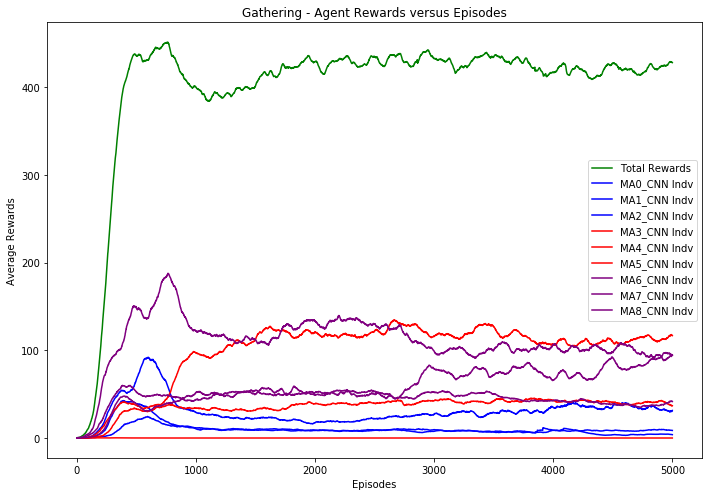

results/3T-9L1R/warlike/p-1.0_r0.001/
Max. Running Reward - MA0 Ind Reward: 37.626
Max. Running Reward - MA1 Ind Reward: 130.171
Max. Running Reward - MA2 Ind Reward: 36.256
Max. Running Reward - MA3 Ind Reward: 131.511
Max. Running Reward - MA4 Ind Reward: 64.006
Max. Running Reward - MA5 Ind Reward: 66.095
Max. Running Reward - MA6 Ind Reward: 66.066
Max. Running Reward - MA7 Ind Reward: 67.199
Max. Running Reward - MA8 Ind Reward: 138.859
Max. Running Reward - All Agents: 485.877
Tribe 0 Sum Reward: 182.082
Tribe 1 Sum Reward: 165.293
Tribe 2 Sum Reward: 198.612




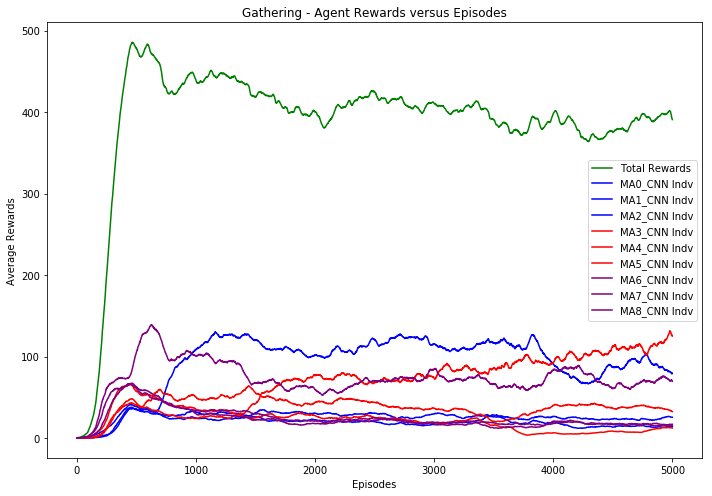

results/3T-9L1R/warlike/p-1.0_r0.005/
Max. Running Reward - MA0 Ind Reward: 47.282
Max. Running Reward - MA1 Ind Reward: 64.624
Max. Running Reward - MA2 Ind Reward: 113.944
Max. Running Reward - MA3 Ind Reward: 23.455
Max. Running Reward - MA4 Ind Reward: 61.245
Max. Running Reward - MA5 Ind Reward: 139.385
Max. Running Reward - MA6 Ind Reward: 45.422
Max. Running Reward - MA7 Ind Reward: 92.552
Max. Running Reward - MA8 Ind Reward: 101.923
Max. Running Reward - All Agents: 463.350
Tribe 0 Sum Reward: 213.210
Tribe 1 Sum Reward: 82.325
Tribe 2 Sum Reward: 186.396




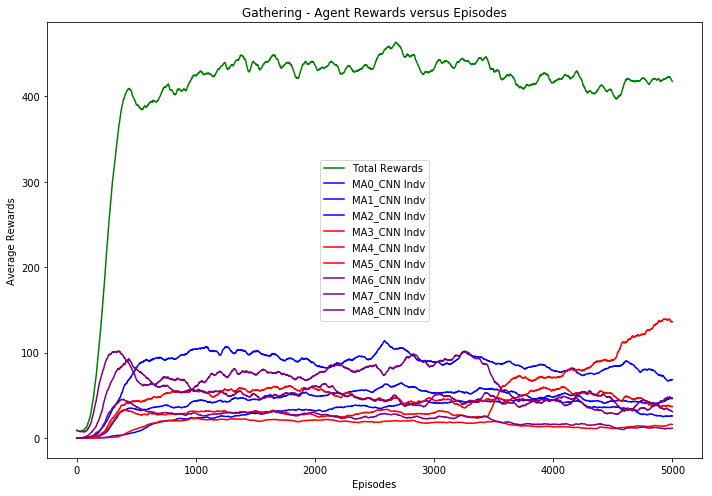

results/3T-9L1R/warlike/p-1.0_r0.01/
Max. Running Reward - MA0 Ind Reward: 16.516
Max. Running Reward - MA1 Ind Reward: 31.376
Max. Running Reward - MA2 Ind Reward: 15.606
Max. Running Reward - MA3 Ind Reward: 0.203
Max. Running Reward - MA4 Ind Reward: 44.343
Max. Running Reward - MA5 Ind Reward: 152.026
Max. Running Reward - MA6 Ind Reward: 47.570
Max. Running Reward - MA7 Ind Reward: 90.174
Max. Running Reward - MA8 Ind Reward: 136.655
Max. Running Reward - All Agents: 419.047
Tribe 0 Sum Reward: 62.598
Tribe 1 Sum Reward: 44.343
Tribe 2 Sum Reward: 252.151




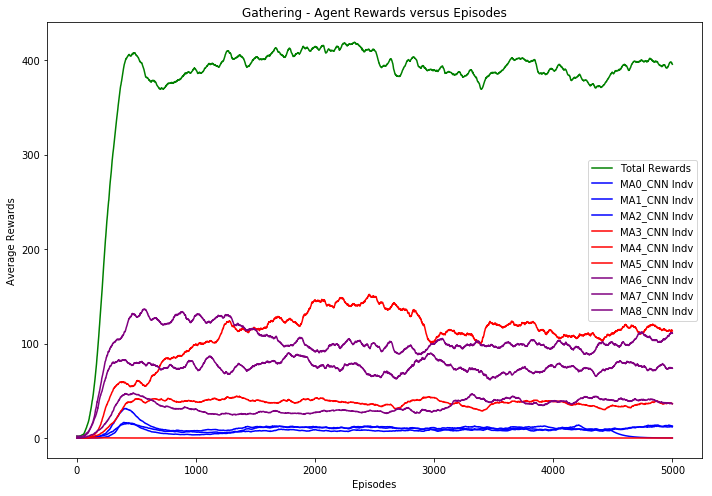

results/3T-9L1R/warlike/p-1.0_r0.05/
Max. Running Reward - MA0 Ind Reward: 54.471
Max. Running Reward - MA1 Ind Reward: 125.678
Max. Running Reward - MA2 Ind Reward: 115.131
Max. Running Reward - MA3 Ind Reward: 25.274
Max. Running Reward - MA4 Ind Reward: 13.540
Max. Running Reward - MA5 Ind Reward: 130.764
Max. Running Reward - MA6 Ind Reward: 65.658
Max. Running Reward - MA7 Ind Reward: 434.520
Max. Running Reward - MA8 Ind Reward: 92.028
Max. Running Reward - All Agents: 539.598
Tribe 0 Sum Reward: 225.851
Tribe 1 Sum Reward: 36.081
Tribe 2 Sum Reward: 441.537




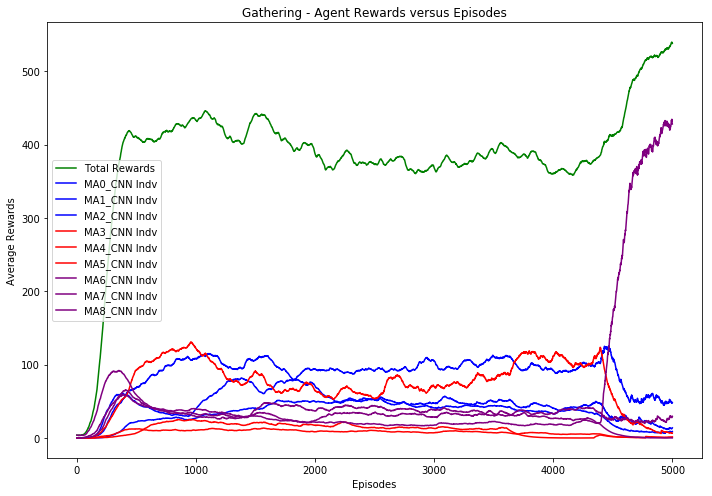

results/3T-9L1R/warlike/p-1.0_r0.1/
Max. Running Reward - MA0 Ind Reward: 99.917
Max. Running Reward - MA1 Ind Reward: 493.350
Max. Running Reward - MA2 Ind Reward: 21.262
Max. Running Reward - MA3 Ind Reward: 0.116
Max. Running Reward - MA4 Ind Reward: 62.549
Max. Running Reward - MA5 Ind Reward: 70.150
Max. Running Reward - MA6 Ind Reward: 80.699
Max. Running Reward - MA7 Ind Reward: 64.798
Max. Running Reward - MA8 Ind Reward: 104.795
Max. Running Reward - All Agents: 650.136
Tribe 0 Sum Reward: 590.366
Tribe 1 Sum Reward: 62.549
Tribe 2 Sum Reward: 209.364




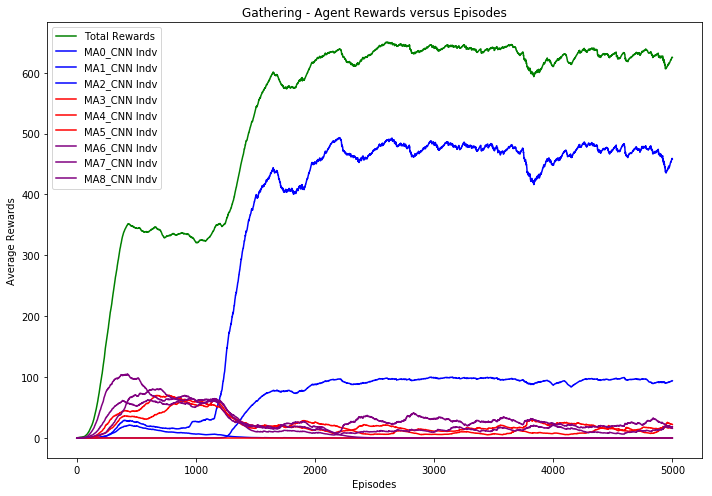

results/3T-9L1R/warlike/p-1.0_r0.5/
Max. Running Reward - MA0 Ind Reward: 0.060
Max. Running Reward - MA1 Ind Reward: 0.000
Max. Running Reward - MA2 Ind Reward: 0.000
Max. Running Reward - MA3 Ind Reward: 0.110
Max. Running Reward - MA4 Ind Reward: 0.180
Max. Running Reward - MA5 Ind Reward: 0.000
Max. Running Reward - MA6 Ind Reward: 0.020
Max. Running Reward - MA7 Ind Reward: 0.565
Max. Running Reward - MA8 Ind Reward: 0.358
Max. Running Reward - All Agents: 1.151
Tribe 0 Sum Reward: 0.060
Tribe 1 Sum Reward: 0.252
Tribe 2 Sum Reward: 0.575




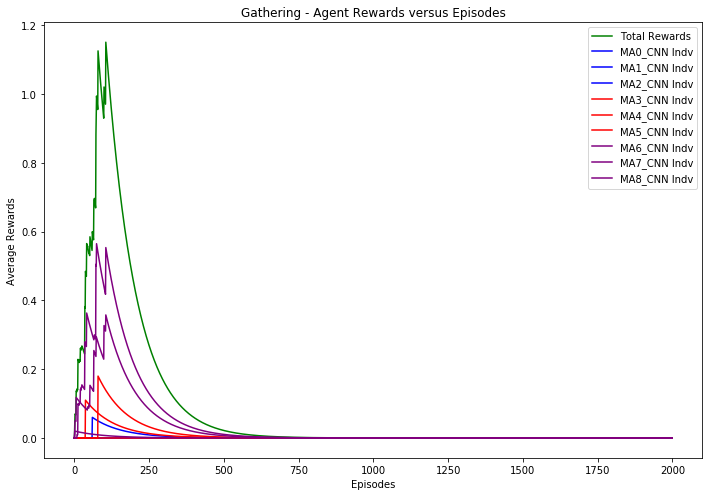

results/3T-9L1R/warlike/p-1.0_r1.0/
Max. Running Reward - MA0 Ind Reward: 0.000
Max. Running Reward - MA1 Ind Reward: 0.010
Max. Running Reward - MA2 Ind Reward: 0.060
Max. Running Reward - MA3 Ind Reward: 0.000
Max. Running Reward - MA4 Ind Reward: 0.080
Max. Running Reward - MA5 Ind Reward: 0.010
Max. Running Reward - MA6 Ind Reward: 0.000
Max. Running Reward - MA7 Ind Reward: 0.522
Max. Running Reward - MA8 Ind Reward: 0.314
Max. Running Reward - All Agents: 0.856
Tribe 0 Sum Reward: 0.068
Tribe 1 Sum Reward: 0.080
Tribe 2 Sum Reward: 0.529




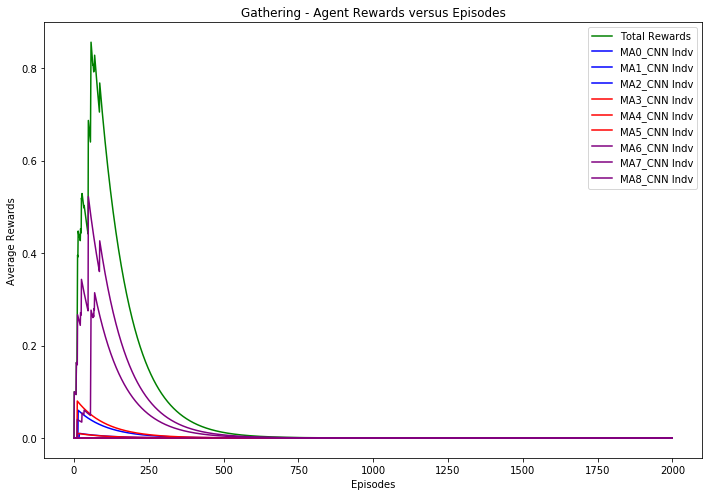

In [4]:
game = 'Gathering'

dir_names = ["results/3T-9L1R/warlike/p-1.0_r0.0001/",
             "results/3T-9L1R/warlike/p-1.0_r0.001/",
             "results/3T-9L1R/warlike/p-1.0_r0.005/",  
             "results/3T-9L1R/warlike/p-1.0_r0.01/",   
             "results/3T-9L1R/warlike/p-1.0_r0.05/",   
             "results/3T-9L1R/warlike/p-1.0_r0.1/",
             "results/3T-9L1R/warlike/p-1.0_r0.5/",
             "results/3T-9L1R/warlike/p-1.0_r1.0/"]

num_learners = 9
num_tribes = 3

# Cultural parameter search
culture = 'warlike'

agents = []
for i in range(num_learners):
    print("Load AI agent {}".format(i))
    agents.append(Policy(4, 8, i))

agents.append(Rdn_Policy())

# Establish tribal association

tribes = []
tribes.append(Tribe(name='Vikings',color='blue', culture=culture, \
                    agents=[agents[0], agents[1], agents[2]]))
tribes.append(Tribe(name='Saxons', color='red', culture=culture, \
                    agents=[agents[3], agents[4], agents[5]]))
tribes.append(Tribe(name='Franks', color='purple', culture=culture, \
                    agents=[agents[6], agents[7], agents[8]]))
tribes.append(Tribe(name='Crazies', color='yellow', agents=[agents[9]]))   # random agents are crazy!!!


# 9 agents in 4 tribes
agent_colors = [agent.color for agent in agents]
agent_tribes = [agent.tribe for agent in agents]

for dir_name in dir_names:
    print (dir_name)
    data = [[] for i in range(num_learners)]
    tribe_data = [[] for i in range(num_tribes)]

    # Load rewards
    for i in range(num_learners):
        data_file = dir_name+'MA{}_Gather.p'.format(i, game)
        with open(data_file, 'rb') as f:
            data[i] = pickle.load(f)

    total = [sum(x) for x in zip(*data)]

    for i in range(num_learners):
        print('Max. Running Reward - MA{} Ind Reward: {:.3f}'.format(i, max(data[i])))

    
    print('Max. Running Reward - All Agents: {:.3f}'.format(max(total)))

    tribe_data[0] = [sum(x) for x in zip(data[0],data[1],data[2])]
    tribe_data[1] = [sum(x) for x in zip(data[3],data[4])]
    tribe_data[2] = [sum(x) for x in zip(data[5],data[6],data[7])]

    for i in range(num_tribes):
        print('Tribe {} Sum Reward: {:.3f}'.format(i, max(tribe_data[i])))
    
    print ('\n')

    plt.figure(figsize=(10, 7))
    plt.plot(total, label='Total Rewards', color='green')
    for i in range(num_learners):
        plt.plot(data[i], label='MA{}_CNN Indv'.format(i), color=agent_colors[i])

    plt.title('{} - Agent Rewards versus Episodes'.format(game))
    plt.xlabel('Episodes')
    plt.ylabel('Average Rewards')
    plt.legend()
    plt.tight_layout()
    plt.show()